In [13]:
import numpy as np
import numpy.linalg as la
from scipy.linalg import inv

%matplotlib inline
%precision 4
import matplotlib.pyplot as plt
import matplotlib as mpl

from my_animate import *
from IPython.display import HTML

# matplotlib preferences
mpl.rcdefaults()  # reset
plt.rc('axes', titlesize=20, labelsize=15)
plt.rc('axes.formatter', limits=[-4, 4])
plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('lines', linewidth=1, markersize=5)
plt.rc('figure', figsize=(5, 5))

## Coursework 3b - Time-dependent advection-diffusion with the FEM

For this problem I again took the lecture 11 approach, requiring more mathematical derivations:

<img src="figs/unsteady_math.jpg" alt="da math">

This gives us an update matrix which is independent of time, hence we can find it once giving a relatively fast time stepping method.

In [14]:
class unsteady_AD():
    """
    This object stores the state of the system and all the parameters that define it.
    The methods are for finding the base functions and matrices as well as time step
    the system and analysing the current state.
    """
    def __init__(self, nodes, theta, u, k, dt, t0):
        """
        Initialse the system. Nodes includes the limits with
        homogenous neumann boundary conditions.
        """
        # store the consants given
        self.dt = dt
        self.theta = theta
        self.u = u
        self.k = k
        self.t = t0
        
        # create the grid
        self.x = np.array(nodes)
        self.dx = np.diff(self.x)
        self.N = self.x.size
        self.lims = [self.x[0], self.x[-1]]
        
        # create the bases functions
        self.bases = [self.base_func(i) for i in range(self.N)]
        self.base_derivs = [self.base_func_deriv(i) for i in range(self.N)]
        
        # find the matrices
        self.M = np.array([self.mat_row(i, 'M') for i in range(self.N)])
        self.K = np.array([self.mat_row(i, 'K') for i in range(self.N)])
        self.R = np.array([self.mat_row(i, 'R') for i in range(self.N)])
        self.update = self.find_update(theta, u, k)
        
        # setup solution
        self.C = self.exact_slution(self.x)
        return
            
    def base_func(self, i):
        "find the i th base function (hat function)"
        assert 0 <= i < self.N, 'i out of range' 
        if i == 0:  # first node
            return lambda x: np.select([np.logical_and(self.x[i] <= x, x <= self.x[i+1])],
                                        [(self.x[i+1]-x)/self.dx[i]], 0.0)
        elif i == self.N-1:  # last node
            return lambda x: np.select([np.logical_and(self.x[i-1] <= x, x <= self.x[i])],
                                        [(x-self.x[i-1])/self.dx[i-1]], 0.0)
        else:
            return lambda x: np.select([np.logical_and(self.x[i-1] <= x, x <= self.x[i]),
                                        np.logical_and(self.x[i] <= x, x <= self.x[i+1])],
                                        [(x-self.x[i-1])/self.dx[i-1],
                                        (self.x[i+1]-x)/self.dx[i]], 0.0)
    
    def base_func_deriv(self, i):
        "find the i th base function derivative"
        assert 0 <= i < self.N, 'i out of range' 
        if i == 0:  # first node
            return lambda x: np.select([np.logical_and(self.x[i] <= x, x <= self.x[i+1])],
                                        [(-1)/self.dx[i]], 0.0)
        elif i == self.N-1:  # last node
            return lambda x: np.select([np.logical_and(self.x[i-1] <= x, x <= self.x[i])],
                                        [(1)/self.dx[i-1]], 0.0)
        else:
            return lambda x: np.select([np.logical_and(self.x[i-1] <= x, x <= self.x[i]),
                                        np.logical_and(self.x[i] <= x, x <= self.x[i+1])],
                                        [(1)/self.dx[i-1],
                                        (-1)/self.dx[i]], 0.0)
    
    def mat_row(self, i, s):
        "Analytically find the i th row of either M, K or R matrices"
        assert 0 <= i < self.N, 'i out of range'
        row = np.zeros(self.N)
        
        if s == 'M':
            if i == 0:  # first node
                row[i] = self.dx[i] / 3
                row[i+1] = self.dx[i+1] / 6
            elif i == self.N-1:  # last node
                row[i-1] = self.dx[i-1] / 6
                row[i] = self.dx[i-1] / 3
            else:
                row[i-1] = self.dx[i-1] / 6
                row[i] = (self.dx[i] + self.dx[i-1]) / 3
                row[i+1] = self.dx[i] / 6
            return row
        
        elif s == 'K':
            if i == 0:  # first node
                row[i] = 1/self.dx[i]
                row[i+1] = -1/self.dx[i]
            elif i == self.N-1:  # last node
                row[i-1] = -1/self.dx[i-1]
                row[i] = 1/self.dx[i-1]
            else:
                row[i-1] = -1/self.dx[i-1]
                row[i] = 1/self.dx[i-1] + 1/self.dx[i]
                row[i+1] = -1/self.dx[i]
            return row
        
        elif s == 'R':
            if i == 0:  # first node
                row[i+1] = 1/2
                row[i] = -1/2
            elif i == self.N-1:  # last node
                row[i] = 1/2
                row[i-1] = -1/2
            else:
                row[i-1] = -1/2
                row[i+1] = 1/2
            return row
        
        else:
            raise ValueError('s must be either K, M, R')

    def find_update(self, theta, u, k):
        "find the update matrix for time steping this system"
        assert 0 <= theta <= 1, 'theta out of range'
        alpha = self.M/self.dt + u * theta * self.R + k * theta * self.K
        beta = self.M/self.dt - u * (1 - theta) * self.R - k * (1-theta) * self.K
        return inv(alpha) @ beta
    
    def exact_slution(self, x, x0=0.5):
        "The exact solution for a guassian centered x0 at t=0 with infinite height"
        x = x - x0
        return np.exp(-(x-self.u*self.t)**2 / (4*self.k*self.t)) / np.sqrt(4*np.pi*self.k*self.t)
            
    def step(self, n=1):
        "Advance the system by n time steps"
        for _ in range(n):
            self.C = self.update @ self.C
            self.t += self.dt

    def plot(self, ax=None, numeric=True, analytical=True):
        """
        Plot the current state of the system
        
        Parameters
        ----------
        ax : matplotlib axes, optional
            The axis to plot on, creates an axis if None given
        numeric : bool, optional
            Plot the numeric result
        analytical : bool, optional
            Plot the analytical result
        
        Returns
        -------
        ax : matplotlib axes
            axis results were plotted on
        """
        if ax == None:
            fig, ax = plt.subplots()
            ax.set(title=r'System at $t=%.4f$ with $\theta=%.2f$' % (self.t, self.theta),
                   xlabel='x', ylabel='C(x, t)')
        if numeric:
            ax.plot(self.x, self.C, 'bo', label='numeric')
        if analytical:
            x_fine = np.linspace(*self.lims, self.N*10)
            ax.plot(x_fine, self.exact_slution(x_fine), 'r-', label='analytic')
        ax.legend()
        return ax

    def error(self):
        "find the RMS at of the system to the analytical solution at the current time"
        exact = self.exact_slution(self.x)
        diff_sq = (exact - self.C)**2
        return np.sqrt(sum(diff_sq)/self.N)


A few things to note about this implementation:

1. The speed could be improved by implementing LU decomposition, however time restraints have prevented this and the run time is reasonable for nodes < 1000

2. The actual time stepping of the system has to be done manually so that the system can be inspected at every stage if desired

Lets test this solver with Forward Euler for problem we have been set. I will animate the result using the my_animate.py function dual-animate, which simply animates two arrays of data with time.

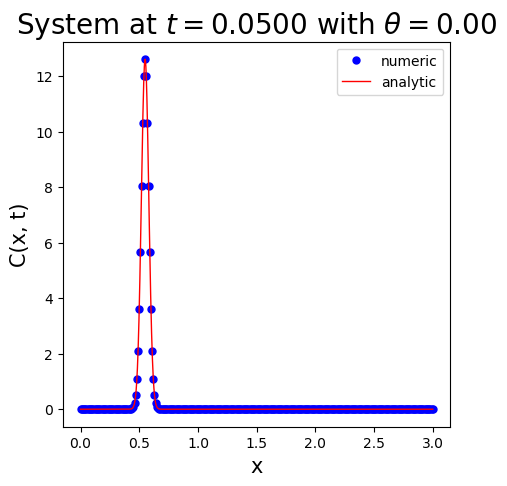

In [15]:
# set up a system and plot the initial state
system = unsteady_AD(np.linspace(0, 3, 301), theta=0, u=1, k=0.01, dt=0.001, t0=0.05)
system.plot()

In [4]:
# arrays to store time frames in
store_num = np.empty((101, system.N))
store_exact = np.empty((101, system.N))

# take 1000 steps and store the system result every 10 steps
for i in range(1000):
    system.step()
    if i % 10 == 0:
        j = int(i/10)
        store_num[j, :] = system.C.copy()
        store_exact[j, :] = system.exact_slution(system.x)

In [16]:
# create the animation
ani_class = dual_animate(store_num, store_exact, system.x, system.dt*10)
ani_class.animate()
ani_class.ax.set(title='Forward Euler Solution', xlabel='x', ylabel='C(x, t)')
plt.close(ani_class.fig)
HTML(ani_class.ani.to_jshtml())

We can see the solver is working over this range reasonably by eye. However how it behaves at the boundaries is still unknown (but we are only asked to solve for this problem).

Lets check the implicit methods are also working by using non-zero theta.

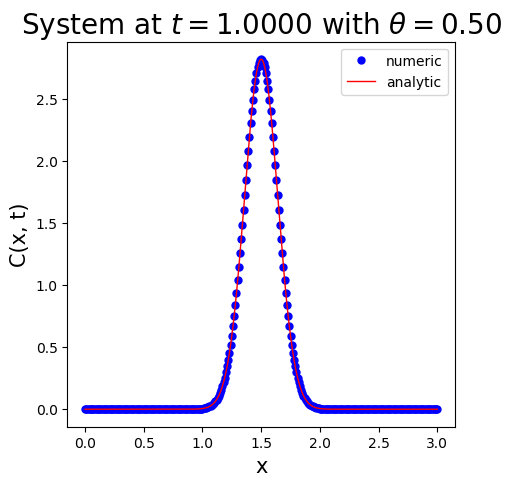

In [17]:
# test crank nicolson
system = unsteady_AD(np.linspace(0, 3, 301), theta=0.5, u=1, k=0.01, dt=0.001, t0=0.05)
no_steps = int((1-0.05)/0.001)+1
system.step(n=no_steps)
system.plot()

This solution seems reasonable by eye too, now I should do a more rigorous check with convergence plots.

Forward Euler has stability criteria that requires certain parameters to converge. Rather than analyse these specifically I will trial and error a bit for dx and dt that work. One also needs to consider the spacial grid with regard to the initial conditions, too large a dx will not register the relatively narrow peak at $t=0.5$, so there is a minimum bound on our dx choice too.

In time analysis we need dt error to dominate. For Crank-Nicolson it is required that dx is much less than dt else the dx error will dominate (not an issue for F/B Euler as they have a lower error order in time). This and the restraint on Forward Euler stability means it makes sense to do these convergence tests separately.

Caution must be taken with dt when it comes to error comparison at the final time, here taken to be $1.05$s so the solver is over 1 second. I will assume the error changes slowly enough that results within dt of the final time have the same error as at the final time. This gives me more freedom in my choice of dt, which is more significant for finding the error order as it allows me to sample the linear region of convergence plots more.

In [18]:
# Time convergence Forward and Backward Euler
# choice of parameters
Ns = np.arange(14,28)
dts = 1/(1.5)**Ns
Nx = 151

# loop over dt choices
errors = np.empty((2, dts.size))
for i,dt in enumerate(dts):
    # set up the systems
    system_FE = unsteady_AD(np.linspace(0, 3, Nx), theta=0, u=1, k=0.01, dt=dt, t0=0.05)
    system_BE = unsteady_AD(np.linspace(0, 3, Nx), theta=1, u=1, k=0.01, dt=dt, t0=0.05)
    
    # number of steps needed
    n = int((1.05-0.05)/dt)
    
    # loop over methods
    for j,s in enumerate([system_FE, system_BE]):
        print('solving method number', j, 'for step', dt)
        s.step(n)
        assert abs(s.t - 1.05) < dt, 'not at the correct final time, t=%f' % s.t
        errors[j, i] = s.error()

print('finished :)')

solving method number 0 for step 0.0034254873907817508
solving method number 1 for step 0.0034254873907817508
solving method number 0 for step 0.002283658260521167
solving method number 1 for step 0.002283658260521167
solving method number 0 for step 0.0015224388403474447
solving method number 1 for step 0.0015224388403474447
solving method number 0 for step 0.0010149592268982965
solving method number 1 for step 0.0010149592268982965
solving method number 0 for step 0.0006766394845988643
solving method number 1 for step 0.0006766394845988643
solving method number 0 for step 0.0004510929897325762
solving method number 1 for step 0.0004510929897325762
solving method number 0 for step 0.0003007286598217175
solving method number 1 for step 0.0003007286598217175
solving method number 0 for step 0.00020048577321447834
solving method number 1 for step 0.00020048577321447834
solving method number 0 for step 0.00013365718214298556
solving method number 1 for step 0.00013365718214298556
solving 

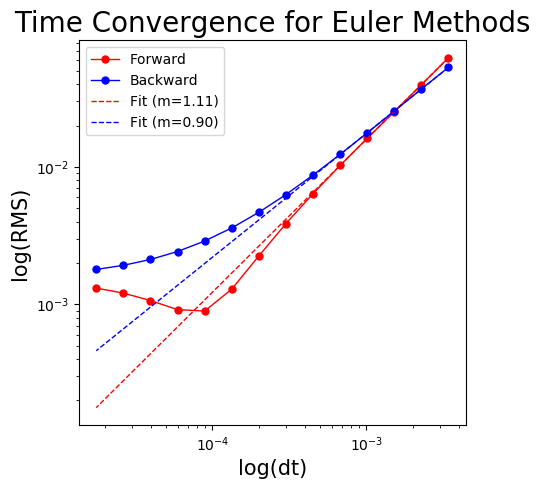

In [19]:
# plot the convergence
plt.loglog(dts, errors[0, :], 'r-o', label='Forward')
plt.loglog(dts, errors[1, :], 'b-o', label='Backward')

# plot the linear fits
log_dts = np.log10(dts)
F_params = np.polyfit(log_dts[:5], np.log10(errors[0, :5]), 1)
B_params = np.polyfit(log_dts[:5], np.log10(errors[1, :5]), 1)
plt.loglog(dts,10**F_params[1] * dts**F_params[0], 'r--', label='Fit (m=%.2f)'%F_params[0])
plt.loglog(dts,10**B_params[1] * dts**B_params[0], 'b--', label='Fit (m=%.2f)'%B_params[0])

plt.gca().set(title='Time Convergence for Euler Methods', xlabel='log(dt)', ylabel='log(RMS)')
plt.legend()

Note only the linear regions have been used for the fitting.

This plot is very similar to what was found in ACSE3 coursework 2, which is what we would expect as the time discretisation is identical for FE and FD and time is the dominant error so any differences in spacial methodology would likely change the numerical values but not the overall shape. However here we think the FD and FE methods reduce to the same thing for this problem.

As such all the previous results notes are applicable here, namely:

1. Both methods have same time order of error $\mathcal{O}(dt) \sim 1$ with Forward being slightly better and backward slightly worse likely due to some specific property of this equation/parameter set (e.g. constant underestimation of positive curvature benefits this solution).

2. Both methods have same space order error as both level off to the same error when dx becomes dominant. Though Forward Euler approaches from below unexpectedly due a to being optimal at around $dt=10^{-4}$, this is possibly due to whatever affect making it slightly better than 1st order being significant here.



In [20]:
# Time convergence for crank nicolson
Ns = np.arange(2,18)
dts = 1/(1.5)**Ns
Nx = 601

errors = np.empty((1, dts.size))
for i,dt in enumerate(dts):
    # set up the systems
    system_CR = unsteady_AD(np.linspace(0, 3, Nx), theta=0.5, u=1, k=0.01, dt=dt, t0=0.05)
    
    # number of steps needed
    n = int((1.05-0.05)/dt)
    
    for j,s in enumerate([system_CR]):
        print('solving method number', j, 'for step', dt)
        s.step(n)
        assert abs(s.t - 1.05) < dt, 'not at the correct time, t=%f' % s.t
        errors[j, i] = s.error()
print('finished :)')

solving method number 0 for step 0.4444444444444444
solving method number 0 for step 0.2962962962962963
solving method number 0 for step 0.19753086419753085
solving method number 0 for step 0.13168724279835392
solving method number 0 for step 0.0877914951989026
solving method number 0 for step 0.05852766346593507
solving method number 0 for step 0.03901844231062338
solving method number 0 for step 0.02601229487374892
solving method number 0 for step 0.017341529915832612
solving method number 0 for step 0.011561019943888409
solving method number 0 for step 0.0077073466292589396
solving method number 0 for step 0.005138231086172626
solving method number 0 for step 0.0034254873907817508
solving method number 0 for step 0.002283658260521167
solving method number 0 for step 0.0015224388403474447
solving method number 0 for step 0.0010149592268982965
finished :)


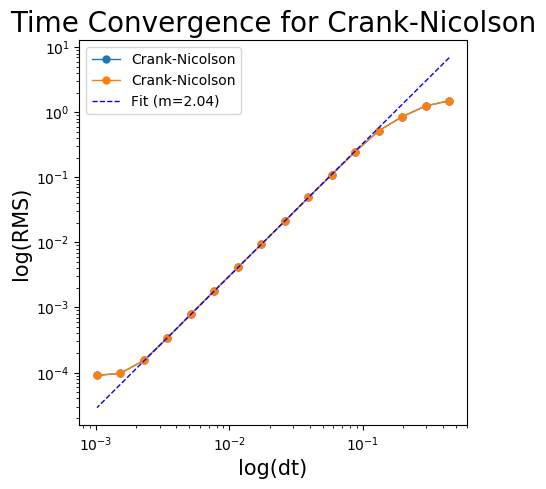

In [21]:
plt.figure()

# plot the convergence
plt.loglog(dts, errors[0, :], '-o', label='Crank-Nicolson')

# plot the convergence
plt.loglog(dts, errors[0, :], '-o', label='Crank-Nicolson')

# plot the linear fits
log_dts = np.log10(dts)
CN_params = np.polyfit(log_dts[5:-3], np.log10(errors[0, 5:-3]), 1)
plt.loglog(dts,10**CN_params[1] * dts**CN_params[0], 'b--', label='Fit (m=%.2f)'%CN_params[0])

plt.gca().set(title='Time Convergence for Crank-Nicolson', xlabel='log(dt)', ylabel='log(RMS)')
plt.legend()
plt.show()


This is looking very similar to ACSE3-2 as well. The error order is $\mathcal{O}(dt) \sim 2$, though slightly better likely due to the same factor as for Forward Euler or possibly due to my evaluation of the error not being exactly on the same final time. In the low dt limit we see dx dominating at a lower error value than for the Euler's but here dx is chosen to be smaller so the comparison is not that significant. At high dt we see higher order error terms being more significant, so the plot levels off.

These error orders to the first significant figure for agree with the theory expected for these discretisation schemes (Euler$=1$, central/CN$=2$).

Now I will do the spacial convergence. All are expected to have the same convergence order here as all are central difference in space, so I will do all methods at once here.

In [22]:
# Space Convergence
Ns = np.arange(12, 20)
Nxs = (1.4**Ns).astype(int)
dxs = 1/Nxs
dt = 0.00002
n = int((1.05-0.05)/dt)+1  # number of steps needed

errors = np.empty((3, Nxs.size))
for i, Nx in enumerate(Nxs):
    # set up the systems
    system_FE = unsteady_AD(np.linspace(0, 3, Nx), theta=0, u=1, k=0.01, dt=dt, t0=0.05)
    system_BE = unsteady_AD(np.linspace(0, 3, Nx), theta=1, u=1, k=0.01, dt=dt, t0=0.05)
    system_CR = unsteady_AD(np.linspace(0, 3, Nx), theta=0.5, u=1, k=0.01, dt=dt, t0=0.05)
    
    for j, s in enumerate([system_FE, system_BE, system_CR]):
        print('solving method number', j, 'for step', 3/Nx)
        s.step(n)
        assert abs(s.t - 1.05) < dt, 'not at the correct time, t=%f' % s.t
        errors[j, i] = s.error()
print('finished :)')

solving method number 0 for step 0.05357142857142857
solving method number 1 for step 0.05357142857142857
solving method number 2 for step 0.05357142857142857
solving method number 0 for step 0.0379746835443038
solving method number 1 for step 0.0379746835443038
solving method number 2 for step 0.0379746835443038
solving method number 0 for step 0.02702702702702703
solving method number 1 for step 0.02702702702702703
solving method number 2 for step 0.02702702702702703
solving method number 0 for step 0.01935483870967742
solving method number 1 for step 0.01935483870967742
solving method number 2 for step 0.01935483870967742
solving method number 0 for step 0.013824884792626729
solving method number 1 for step 0.013824884792626729
solving method number 2 for step 0.013824884792626729
solving method number 0 for step 0.009868421052631578
solving method number 1 for step 0.009868421052631578
solving method number 2 for step 0.009868421052631578
solving method number 0 for step 0.00704225

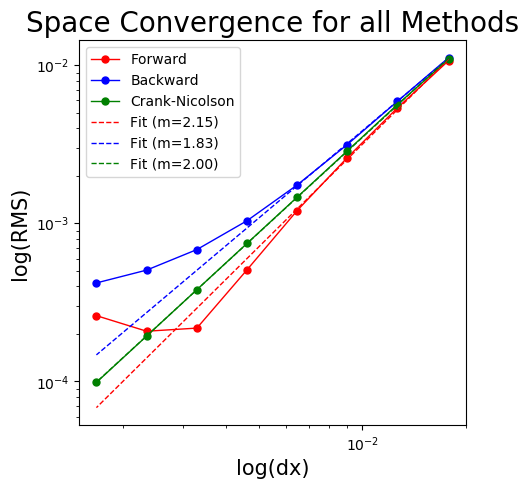

In [23]:
plt.figure()

# plot the errors
plt.loglog(dxs, errors[0, :], 'r-o', label='Forward')
plt.loglog(dxs, errors[1, :], 'b-o', label='Backward')
plt.loglog(dxs, errors[2, :], 'g-o', label='Crank-Nicolson')

# plot the linear fits
log_dxs = np.log10(dxs)
F_params = np.polyfit(log_dxs[:-4], np.log10(errors[0, :-4]), 1)
B_params = np.polyfit(log_dxs[:-4], np.log10(errors[1, :-4]), 1)
CN_params = np.polyfit(log_dxs[:], np.log10(errors[2, :]), 1)
plt.loglog(dxs, 10**F_params[1] * dxs**F_params[0], 'r--', label='Fit (m=%.2f)'%F_params[0])
plt.loglog(dxs, 10**B_params[1] * dxs**B_params[0], 'b--', label='Fit (m=%.2f)'%B_params[0])
plt.loglog(dxs, 10**CN_params[1] * dxs**CN_params[0], 'g--', label='Fit (m=%.2f)'%CN_params[0])

plt.gca().set(title='Space Convergence for all Methods', xlabel='log(dx)', ylabel='log(RMS)')
plt.legend()
plt.show()


Here I have chosen the dx as large as possible without causing instability from the lack of sampling the initial distribution whilst not solving for dx smaller than the dt dominance for the Euler methods. Again I have only fitted to the linear regions of the plots, ignoring the plateau for the Euler methods.

In general all methods have error order $\mathcal{O}(dx) \sim 2$, with similar absolute values, as expect due to them all being central in space.
We also see similar trends the time plots in that Forward is a little better than expected and backwards a little worse (again as seen in ACSE3-2). This is further evidence that Forward Euler is more suited to this particular problem for some reason than backwards.
We see Crank-Nicolson as the middle ground in terms of gradient (again as expect since it is a combination of the other two methods) and it does not plateau as the other two do due to being higher order in time.